In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: unexpected EOF while parsing (<ipython-input-2-583db37e43a6>, line 17)

# **Information About dataset**

# CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including,10,177 number of identities,202,599 number of face images, and 5 landmark locations, 40 binary attributes annotations per image.

<img src= "https://mmlab.ie.cuhk.edu.hk/projects/CelebA/intro.png" alt ="Celaba">

# Bussiness Problem:

**To create an Algorithm, which can predict 5 Similar faces, given an input Image.**

In [4]:
########### Importing the necessary files
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
import shutil
import os
import warnings as wrn
wrn.filterwarnings('ignore')
tf.__version__

'2.4.1'

In [5]:
# Initialize the random number generator
import random
random.seed(0)

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')           ############ Remove the comments, if data is stored in google drive

In [7]:
############### folder definition
project_folder= './'
image_path= '../input/celeba-dataset/img_align_celeba/img_align_celeba/'
input_path= '../input/'
dataset_zip_name= 'img_align_celeba.zip'
indentity_csv_dir= '../input/identity/identity.csv'
vgg_weights_dir= '../input/vgg-face/vgg_face_weights.h5'

### Throughout the script, these folders name has been used. Kindly update it as per your directory


In [8]:
#os.chdir(project_folder)
#with zipfile.ZipFile(project_folder+zip_name,"r") as CelebB:                  ############ Remove the comments,to retrieve the data zip file. The Zip file and CSV file is present in below  link : 
#  CelebB.extractall(project_folder)                                           ############## https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [9]:
identity_data=pd.read_csv(indentity_csv_dir)  ### Reading CSV file
identity_data.sort_values('identity',inplace=True) #### sorting the data based on identity
identity_data.reset_index(inplace=True)           ## reset the index
identity_data.drop(columns='index',inplace=True) ## droping the index column
identity_data.head()

,image_id,identity
0,056279.jpg,1
1,145590.jpg,1
2,068169.jpg,1
3,000023.jpg,1
4,024091.jpg,1


In [10]:
identity_data.info()
print('The total number of celebrities availabe in dataset is: ',identity_data.identity.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  202599 non-null  object
 1   identity  202599 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB
The total number of celebrities availabe in dataset is:  10177


#### Total Nuber of celebrities available is 10177 and total images available is 202599

In [11]:
########## creating a path column for the images
path=[]
for i in range(len(identity_data)):
  new_path=image_path+identity_data.image_id[i]
  path.append(new_path)
  #identity_data['path'][i]=new_path

identity_data['path']=path
identity_data.head()

,image_id,identity,path
0,056279.jpg,1,../input/celeba-dataset/img_align_celeba/img_a...
1,145590.jpg,1,../input/celeba-dataset/img_align_celeba/img_a...
2,068169.jpg,1,../input/celeba-dataset/img_align_celeba/img_a...
3,000023.jpg,1,../input/celeba-dataset/img_align_celeba/img_a...
4,024091.jpg,1,../input/celeba-dataset/img_align_celeba/img_a...


Image shape is:  (218, 178, 3)
Image shape is:  (218, 178, 3)
Image shape is:  (218, 178, 3)
Image shape is:  (218, 178, 3)
Image shape is:  (218, 178, 3)


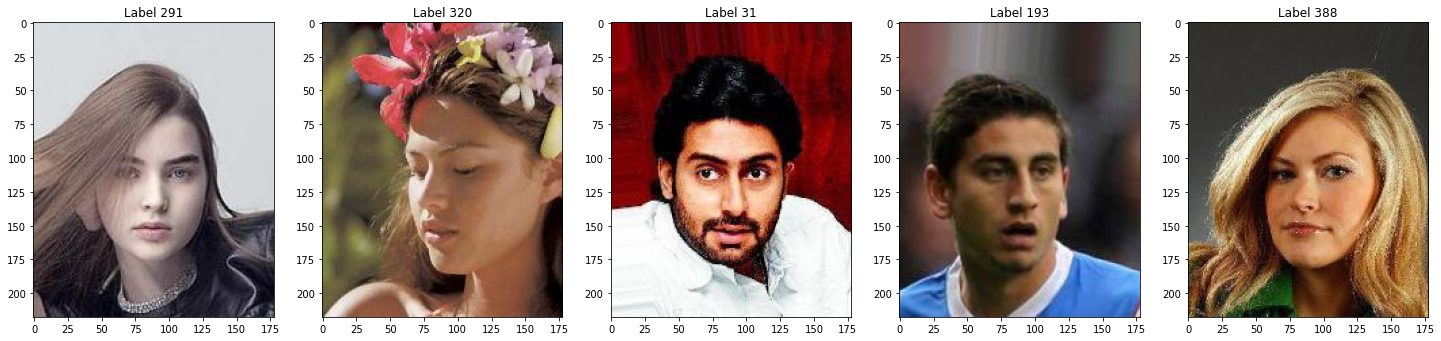

In [12]:
##### Lets plot some random five images

import matplotlib.pyplot as plt
fig= plt.figure(figsize=(25,25))
for i in range(5):
    random_number=random.randint(1,identity_data.identity.nunique())
    img=plt.imread(identity_data.path[random_number])
    plt.subplot(1,5,i+1)
    plt.title('Label {}'.format(identity_data.identity[random_number]))
    print('Image shape is: ',img.shape)
    plt.imshow(img)

# As it can be clearly seen that Image sizes of all the images are (218,178,3). Images looks more clear and No noise is observed in the images. Hence, there is no need to do any image transformation

# Total number of images found to be 202599, for simplicity and RAM issue, lets only consider data of 1000 images

In [13]:
########### Preparing train and test Dataset
meta_data=identity_data[['identity','path']]  ############## data for preprocessing
print('total number of images are: ',len(meta_data))

from sklearn.model_selection import train_test_split
meta_data_sample=meta_data[0:1000]
Train_data,test_data=train_test_split(meta_data_sample,test_size=0.3, random_state=42)
print('The train shape is: ',Train_data.shape)
print('The test shape is: ',test_data.shape)

###### The train and test data is splitted

total number of images are:  202599
The train shape is:  (700, 2)
The test shape is:  (300, 2)


In [14]:
#### Since, the image size is 218,178,3.. for VGG-Net it should be converted into 224,224,3. We can use open-cv library for the same.
import cv2
def image_conversion_ML(datapath):
    """
    This function will convert the image array from [0,255] to [0,1] 
    
    and flatten it.
    
    Input required: datapath: Series dataset containing the path location.
    
    Output: This function will throw the array of flatten images
    
    """
    img_array=[]
    for i,m in enumerate(datapath):
        img=cv2.imread(m)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = (img / 255.).astype(np.float32)
        #img=cv2.resize(img, dsize = (224,224))
        img=img.flatten()
        img_array.append(img)
        #img_array=np.array(img_array).flatten()
        
    #img_array=img_array.reshape(img_array.shape[0],224,224,3) ##### Re
    return np.array(img_array)

In [15]:
#### Since, the image size is 218,178,3.. for VGG-Net it should be converted into 224,224,3. We can use open-cv library for the same.
import cv2
def image_conversion(datapath):
    """
    This function will convert the image array from [0,255] to [0,1]
    
    and it will even, resize the image to 224*224
    
    Input required: datapath: Series dataset containing the path location.
    
    Output: This function will throw the array of images of size 224*224
    
    """
    img_array=[]
    for i,m in enumerate(datapath):
        img=cv2.imread(m)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = (img / 255.).astype(np.float32)
        img=cv2.resize(img, dsize = (224,224))
        img_array.append(img)
    img_array=np.array(img_array)
    img_array=img_array.reshape(img_array.shape[0],224,224,3) ##### Re
    return np.array(img_array)

In [16]:
#### Dataset for Approch-1 (ML)
train_data_ML=image_conversion_ML(Train_data['path'])
test_data_ML=image_conversion_ML(test_data['path'])

X_train_ML=train_data_ML
y_train_ML=np.array(Train_data['identity'])
X_test_ML=test_data_ML
y_test_ML=np.array(test_data['identity'])

print(" The flatten shape of the anyone image is: ",train_data_ML[1].shape,
     "which is same as 218*178*3=116412")

 The flatten shape of the anyone image is:  (116412,) which is same as 218*178*3=116412


In [17]:
#### Dataset for Approch-2 (Deep-learning)
train_data_DL=image_conversion(Train_data['path'])
test_data_DL=image_conversion(test_data['path'])

X_train_DL=train_data_DL
y_train_DL=np.array(Train_data['identity'])
X_test_DL=test_data_DL
y_test_DL=np.array(test_data['identity'])
print(" The  shape of the anyone image is: ",train_data_DL[1].shape,
     "which is same as 224*224*3")

 The  shape of the anyone image is:  (224, 224, 3) which is same as 224*224*3


In [18]:
#### Dataset for Approch-3 (Deep-learning)
train_data_DL1=image_conversion(Train_data['path'])
test_data_DL1=image_conversion(test_data['path'])

X_train_DL1=train_data_DL1
y_train_DL1=np.array(Train_data['identity'])
X_test_DL1=test_data_DL1
y_test_DL1=np.array(test_data['identity'])
print(" The  shape of the anyone image is: ",train_data_DL[1].shape,
     "which is same as 224*224*3")

 The  shape of the anyone image is:  (224, 224, 3) which is same as 224*224*3


In [19]:
####### Defining the Auto_encoder Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D

def AutoEncoder():
    ####### Encoder
    model_AE = Sequential()
    model_AE.add(Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(224,224,3),padding='same'))
    model_AE.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
    
    model_AE.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
    model_AE.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
    
    model_AE.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same'))
    model_AE.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
    
    model_AE.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
    model_AE.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
    
    # Decoder
    model_AE.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
    model_AE.add(UpSampling2D((2,2)))
    
    model_AE.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same'))
    model_AE.add(UpSampling2D((2,2)))
    
    model_AE.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
    model_AE.add(UpSampling2D((2,2)))
    
    model_AE.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
    model_AE.add(UpSampling2D((2,2)))
    
    model_AE.add(Conv2D(3,kernel_size=(3,3),padding='same',activation='sigmoid'))
    return model_AE

model_AE=AutoEncoder()
model_AE.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 512)       1

Total Learnable paramters are 5461251

In [20]:
####### Defining the VGG Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten

def VGG():
    ####### Encoder
    model_VGG = Sequential()
    model_VGG.add(Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(224,224,3),padding='same'))
    model_VGG.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
    
    model_VGG.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
    
    model_VGG.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
    
    model_VGG.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
    
    model_VGG.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
    model_VGG.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
    
    model_VGG.add(Conv2D(4096,kernel_size=(7,7),activation='relu'))
    model_VGG.add(Dropout(0.5))
    
    model_VGG.add(Conv2D(4096,kernel_size=(1,1),activation='relu'))
    model_VGG.add(Dropout(0.5))
    
    model_VGG.add(Conv2D(2622,kernel_size=(1,1)))
    model_VGG.add(Flatten())
    
    return model_VGG

model_VGG=VGG()
model_VGG.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 56, 56, 256)      

# Lets do First Approach using ML

In [21]:
############# train and test dataset
X_train_ML=train_data_ML
y_train_ML=np.array(Train_data['identity'])
X_test_ML=test_data_ML
y_test_ML=np.array(test_data['identity'])

In [23]:
##fitiing the model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=30,algorithm='ball_tree',metric='euclidean')
knn.fit(X_train_ML,y_train_ML)

KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=30)

In [67]:
def plot_fiveImages(res,num):
    """
    This function will plot the 5 Similar images.
    
    Input: 
    
    res: result from knn.kneighnours
    
    num: test image number for which 5 images to be predicted
    
    
    output: five similar images
    """
    fig= plt.figure(figsize=(25,25))
    plt.subplot(1,6,1)
    plt.imshow(X_test_ML[num].reshape((218,178,3)))
    plt.title('User defined image Label {}'.format(y_test_ML[num]))
    for i in np.arange(0,5):
               plt.subplot(1,6,i+2)
               plt.title('Predicted Image and Label {}'.format(y_train_ML[res[0][i]]))
               plt.imshow(X_train_ML[res[0][i]].reshape((218,178,3)))

In [25]:
num = 10 #datapoint
res = knn.kneighbors(X_test_ML[num].reshape(1,-1),return_distance=False,n_neighbors=5)   ############ 5 neighnbour data point
print(res)

[[384 204 503 378 486]]


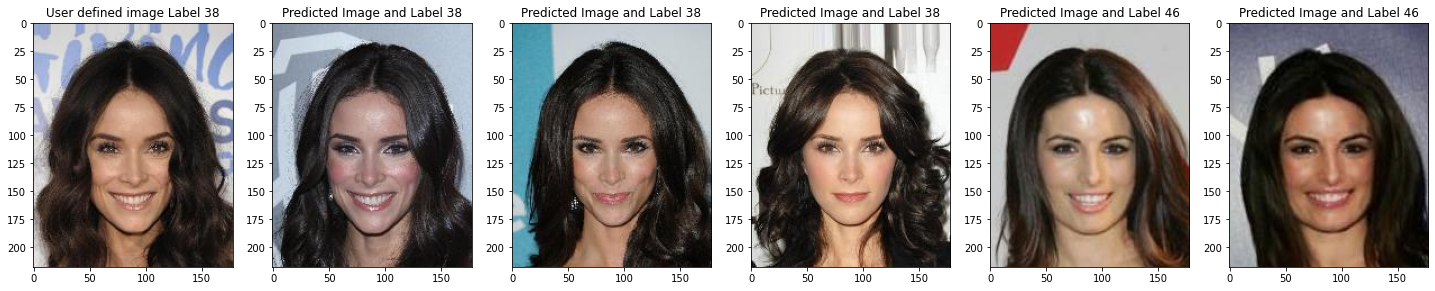

In [27]:
###### plotiing the 5similar images
plot_fiveImages(res,num)

# It can be seen here that out of 5 images to predict, 3 images predcited to be correct. Since, its just a ML approach and Image space is highly scattered. It is difficult to predict correct images. However, Finetuning the model can increase the accuracy

# Lets do Second Approach using AutoEncoder

In [29]:
# Compile the model
model_AE.compile(loss="mean_squared_error", optimizer="adam") 
#Use earlystopping
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.01)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./encoder.h5', monitor='val_loss', mode='min', save_best_only=True) 

In [30]:
### fitting the model
history=model_AE.fit(X_train_DL, X_train_DL, epochs=30, batch_size=20,validation_data=(X_test_DL,X_test_DL),callbacks=[EarlyStopping,checkpoint]) 

Epoch 1/30
35/35 [==============================] - 58s 1s/step - loss: 0.0814 - val_loss: 0.0474
Epoch 2/30
35/35 [==============================] - 46s 1s/step - loss: 0.0274 - val_loss: 0.0158
Epoch 3/30
35/35 [==============================] - 46s 1s/step - loss: 0.0142 - val_loss: 0.0106
Epoch 4/30
35/35 [==============================] - 46s 1s/step - loss: 0.0092 - val_loss: 0.0077
Epoch 5/30
35/35 [==============================] - 46s 1s/step - loss: 0.0077 - val_loss: 0.0071
Epoch 6/30
35/35 [==============================] - 46s 1s/step - loss: 0.0068 - val_loss: 0.0061
Epoch 7/30
35/35 [==============================] - 46s 1s/step - loss: 0.0062 - val_loss: 0.0063


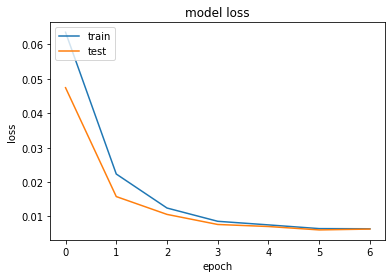

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### The loss seems pretty fine

In [33]:
from tensorflow.keras.models import Model
encoded=Model(inputs=model_AE.layers[0].input, outputs=model_AE.layers[8].output)   ########### encoding for creating the Embeddings

In [34]:
### Train data Embeddings
train_embeddings=np.zeros((X_train_DL.shape[0],14*14*512))

for i in np.arange(0,len(X_train_DL)):
    temp=encoded.predict(np.expand_dims(X_train_DL[i],axis=0))[0]
    temp=temp.reshape(14*14*512)
    train_embeddings[i]=temp

In [35]:
### Test data Embeddings
test_embeddings=np.zeros((X_test_DL.shape[0],14*14*512))

for i in np.arange(0,len(X_test_DL)):
    temp=encoded.predict(np.expand_dims(X_test_DL[i],axis=0))[0]
    temp=temp.reshape(14*14*512)
    test_embeddings[i]=temp

In [60]:
def distance(emb1, emb2):
    """
    this code will find out the Eucledian distance between two Embediings
    
    Input: Enbedding positions
    
    output: Distance between Embeddings
    
    """
    return np.sum(np.square(emb1 - emb2))


import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    """
    this code will plot the pairs with distance between two images
    
    """
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(train_embeddings[idx1], train_embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(train_data_DL[idx1])
    plt.subplot(122)
    plt.imshow(train_data_DL[idx2]); 

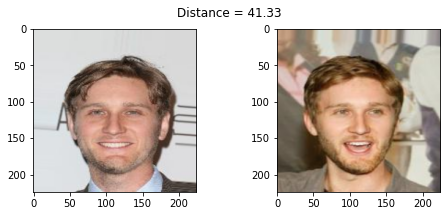

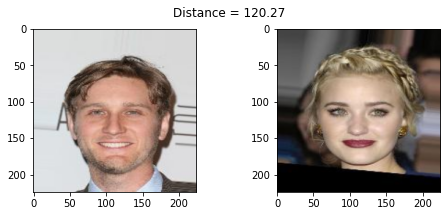

In [61]:
show_pair(1,3)
show_pair(1,20)

# As it is visible that the images closer to eachother is having less distance

In [62]:
X_train_DL=train_embeddings
y_train_DL=np.array(Train_data['identity'])
X_test_DL=test_embeddings
y_test_DL=np.array(test_data['identity'])

In [63]:
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier(n_neighbors=30,algorithm='ball_tree',metric='euclidean')
knn1.fit(X_train_DL,y_train_DL)

KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=30)

In [65]:
num = 10 #datapoint
res = knn1.kneighbors(X_test_DL[num].reshape(1,-1),return_distance=False,n_neighbors=5)
print(res)

[[204 384 503 378 486]]


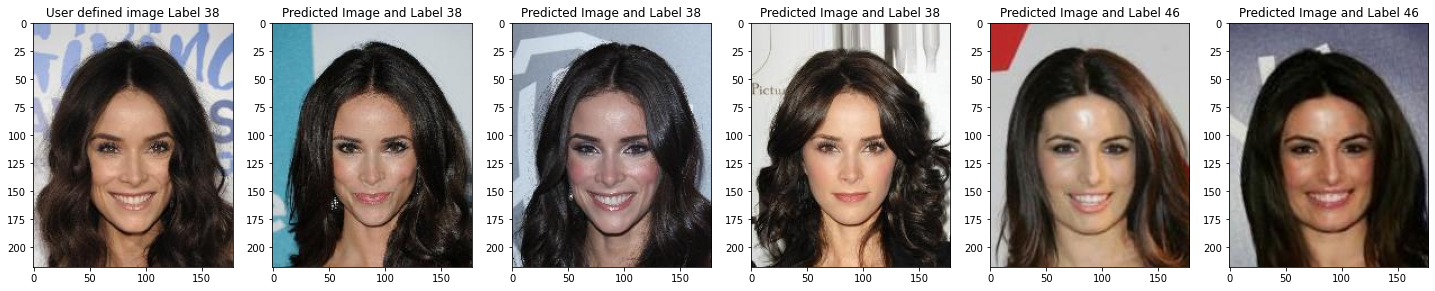

In [68]:
###### plotiing the 5similar images
plot_fiveImages(res,num)

# It can be seen here that out of 5 images to predict, 3 images predcited to be correct. Since, its just a ML approach and Image space is highly scattered. It is difficult to predict correct images. However, Finetuning the model can increase the accuracy

# Lets do third Approach using VGG

In [70]:
model_VGG.load_weights('../input/vgg-face/vgg_face_weights.h5')    ############# Loading the Pretrained VGG-Face weights

In [71]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model_VGG.layers[0].input, outputs=model_VGG.layers[-1].output)   ## creating the descriptor

In [72]:
train_embeddings=np.zeros((train_data_DL1.shape[0],2622))

for i in np.arange(0,len(train_data_DL1)):
    temp=vgg_face_descriptor.predict(np.expand_dims(train_data_DL1[i],axis=0))[0]
    #temp=temp.reshape(14*14*512)
    train_embeddings[i]=temp

In [73]:
test_embeddings=np.zeros((X_test_DL1.shape[0],2622))

for i in np.arange(0,len(X_test_DL1)):
    temp=vgg_face_descriptor.predict(np.expand_dims(X_test_DL1[i],axis=0))[0]
    #temp=temp.reshape(14*14*512)
    test_embeddings[i]=temp

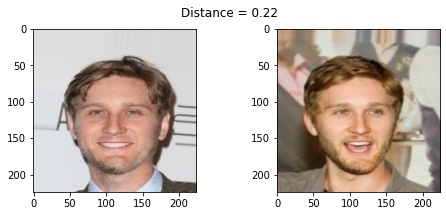

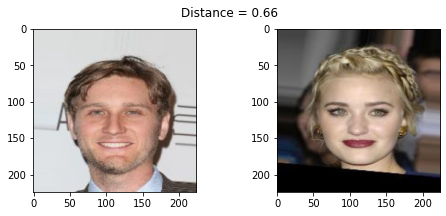

In [75]:
show_pair(1,3)
show_pair(1,20)

# As it is visible that the images closer to eachother is having less distance

In [76]:
X_train_DL1=train_embeddings
y_train_DL1=np.array(Train_data['identity'])
X_test_DL1=test_embeddings
y_test_DL1=np.array(test_data['identity'])

In [77]:
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier(n_neighbors=30,algorithm='ball_tree',metric='euclidean')
knn1.fit(X_train_DL1,y_train_DL1)

KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=30)

In [78]:
num = 10 #datapoint
res = knn1.kneighbors(X_test_DL1[num].reshape(1,-1),return_distance=False,n_neighbors=5)
print(res)

[[544 384 283 673 204]]


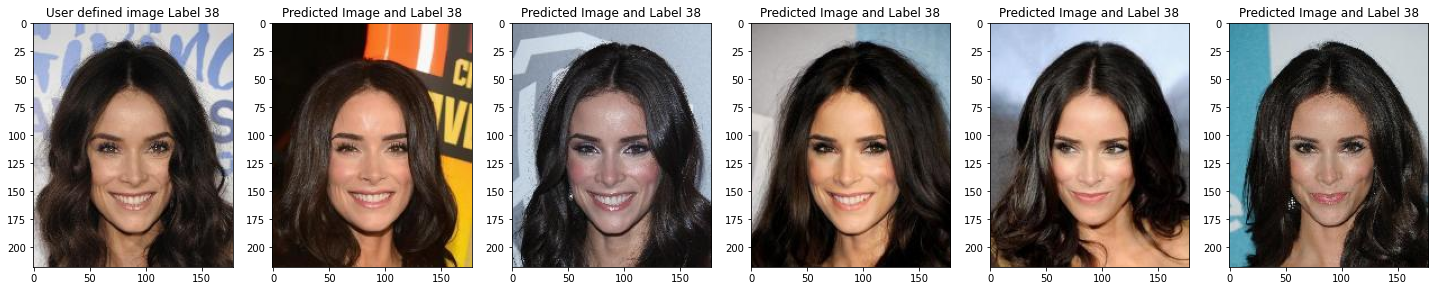

In [79]:
###### plotiing the 5similar images
plot_fiveImages(res,num)

# As It can be seen clearly, here that the algorithm is able to predict all similar images